# West Nile Virus: Model Tuning(without Codesum)
---

## Content
---

- [Locations](../code/99_Locations.ipynb)
- [Data Cleaning Summary](../code/01_Data_Cleaning.ipynb) 
- [Train-test Investigation](../code/01a_Train_Test_Investigation.ipynb) 
- [Weather Investigation](../code/01b_Weather_Investigation.ipynb) 
- [Spray Investigation](../code/01c_Spray_Investigation.ipynb) 
- [Feature Engineering](../code/02a_Feature_Engineering.ipynb) 
- [Combined EDA and Preprocessing](../code/02b_Combined_EDA_and_Preprocessing.ipynb) 
- [Model Tuning & Conclusion](../code/03_Model_Tuning_&_Conclusion.ipynb) **Current Notebook**

## Import Library
---

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn import svm
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,\
                            BaggingClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve,\
                            roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from xgboost import XGBClassifier

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import pickle

## Import datasets

In [ ]:
train_exp5 = pd.read_csv('../assets/train_final_v2_daylight_exp5.csv')
train_exp5.shape

(7370, 38)

In [ ]:
train_exp5.head(3)

,Latitude,Longitude,WnvPresent,species_culex_erraticus,species_culex_pipiens,species_culex_pipiens_restuans,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,species_unspecified_culex,month_of_year,week_of_year,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Tavg_mean_past7day,WetBulb_mean_past7day,Heat_mean_past7day,Cool_mean_past7day,AvgSpeed_mean_past7day,PrecipTotal_mean_past7day,Tavg_mean_past14day,WetBulb_mean_past14day,Heat_mean_past14day,Cool_mean_past14day,AvgSpeed_mean_past14day,PrecipTotal_mean_past14day,daylight_duration_in_minutes
0,41.954690,-87.800991,0,0,0,1,0,0,0,0,0,5,22,74,10,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,68.0,58.571429,1.428571,4.428571,9.485714,0.153143,64.142857,54.142857,3.714286,2.857143,9.85,0.091571,896.0
1,41.954690,-87.800991,0,0,0,0,1,0,0,0,0,5,22,74,10,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,68.0,58.571429,1.428571,4.428571,9.485714,0.153143,64.142857,54.142857,3.714286,2.857143,9.85,0.091571,896.0
2,41.994991,-87.769279,0,0,0,0,1,0,0,0,0,5,22,74,10,58,65,0,9,0.0,29.39,30.11,5.8,18,6.5,68.0,58.571429,1.428571,4.428571,9.485714,0.153143,64.142857,54.142857,3.714286,2.857143,9.85,0.091571,896.0


In [ ]:
train_exp5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7370 entries, 0 to 7369
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Latitude                        7370 non-null   float64
 1   Longitude                       7370 non-null   float64
 2   WnvPresent                      7370 non-null   int64  
 3   species_culex_erraticus         7370 non-null   int64  
 4   species_culex_pipiens           7370 non-null   int64  
 5   species_culex_pipiens_restuans  7370 non-null   int64  
 6   species_culex_restuans          7370 non-null   int64  
 7   species_culex_salinarius        7370 non-null   int64  
 8   species_culex_tarsalis          7370 non-null   int64  
 9   species_culex_territans         7370 non-null   int64  
 10  species_unspecified_culex       7370 non-null   int64  
 11  month_of_year                   7370 non-null   int64  
 12  week_of_year                    73

In [ ]:
X = train_exp5.loc[:,[c for c in train_exp5.columns if c != 'WnvPresent']]
y = train_exp5.loc[:,'WnvPresent']
print(X.shape)
print(y.shape)

(7370, 37)
(7370,)


## Define Baseline Model
---

In [ ]:
train_exp5.loc[:, 'WnvPresent'].value_counts(normalize=True)

0    0.946133
1    0.053867
Name: WnvPresent, dtype: float64

We define baseline model as naively predicting for the majority class for every instance of observation. Hence, with reference to our train dataset class proportions, our baseline accuracy would be 91.94%.

## Function for Modeling
---

In [ ]:
# Instiantiate models
models = {'lr': LogisticRegression(random_state=42),
          'knn': KNeighborsClassifier(),
          'dt': DecisionTreeClassifier(random_state=42),
          'bag': BaggingClassifier(random_state=42),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'svc': SVC(random_state=42),
          'xgb': xgb.XGBClassifier(random_state=42)}

In [ ]:
# Create list to store model testing results
eval_list = []

## Train-Test Split
---

In [ ]:
#Train-Test-Split Function
def process(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                        test_size=0.25, stratify=y)
    
    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    return ss, X_train_sc, X_test_sc, y_train, y_test


In [ ]:
ss, X_train_sc, X_test_sc, y_train, y_test = process(X, y)
print(f'The Shape of X_train_sc: {X_train_sc.shape}')
print(f'The Shape of X_test_sc: {X_test_sc.shape}')
print(f'The Shape of y_train: {y_train.shape}')
print(f'The Shape of y_test: {y_test.shape}')

The Shape of X_train_sc: (5527, 37)
The Shape of X_test_sc: (1843, 37)
The Shape of y_train: (5527,)
The Shape of y_test: (1843,)


In [ ]:
# Function to run model
def run_model(model_name, mod, mod_params={}, grid_search=False, smote_flag=False):
    
    results = {}
    results['model'] = model_name
    
    # SMOTE
    if smote_flag:
        sm = SMOTE()
        X_train_smote, y_train_smote = sm.fit_sample(X_train_sc, y_train)

        if grid_search:
            gs = GridSearchCV(mod, param_grid = {**mod_params}, cv=5, verbose=1, n_jobs=-1)
            gs.fit(X_train_smote, y_train_smote)
            mod = gs
            results['params'] = gs.best_params_
            
        else:
            mod.fit(X_train_smote, y_train_smote)
            results['params'] = 'Default'
        
        # Retrieve metrics
        results['train'] = mod.score(X_train_smote, y_train_smote)
        results['test'] = mod.score(X_test_sc, y_test)
        predictions = mod.predict(X_test_sc)
        results['roc'] = roc_auc_score(y_test, predictions)
        results['specificity'] = precision_score(y_test, predictions)
        results['sensitivity'] = recall_score(y_test, predictions)
        results['f_score'] = f1_score(y_test, predictions)
        eval_list.append(results)
        display(results)

        print('### METRICS ###')
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")

        ########## Ploting the Confusion Matrix and ROC-AUC Curve ##########
        sns.set_style("white")
        fig, ax = plt.subplots(1,2,figsize=(14,5))

        ax = ax.ravel()
        ax[0].set_title('Confusion Matrix',fontsize=18)
        plot_confusion_matrix(mod, X_test_sc, y_test, cmap='Blues', values_format='d',ax=ax[0]);

        ax[1].set_title('ROC-AUC Curve',fontsize=18)
        plot_roc_curve(mod, X_test_sc, y_test,ax=ax[1]);
    
    else: # Non-smote
        if grid_search:
            gs = GridSearchCV(mod, param_grid = {**mod_params}, cv=5, verbose=1, n_jobs=-1)
            gs.fit(X_train_sc, y_train_sc)
            mod = gs
            results['params'] = gs.best_params_
            
        else:
            mod.fit(X_train_sc, y_train_sc)
            results['params'] = 'Default'
        
        # Retrieve metrics
        results['train'] = mod.score(X_train_sc, y_train_sc)
        results['test'] = mod.score(X_test_sc, y_test)
        predictions = mod.predict(X_test_sc)
        results['roc'] = roc_auc_score(y_test, predictions)
        results['specificity'] = precision_score(y_test, predictions)
        results['sensitivity'] = recall_score(y_test, predictions)
        results['f_score'] = f1_score(y_test, predictions)
        eval_list.append(results)
        display(results)
        
        print('### METRICS ###')
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")

        ########## Ploting the Confusion Matrix and ROC-AUC Curve ##########
        sns.set_style("white")
        fig, ax = plt.subplots(1,2,figsize=(14,5))

        ax = ax.ravel()
        ax[0].set_title('Confusion Matrix',fontsize=18)
        plot_confusion_matrix(mod, X_test_sc, y_test, cmap='Blues', values_format='d',ax=ax[0]);

        ax[1].set_title('ROC-AUC Curve',fontsize=18)
        plot_roc_curve(mod, X_test_sc, y_test,ax=ax[1]);
        
    return mod

## Model Benchmark
---

To creat a Benchmark against a model to check if the function is operating as intended.

The Benchmark will first test against an imbalanced dataset and SMOTE to balance, to compare the result against a model(Logistic Regression). These results will be compared against the result obtained from the run_mod function to check its accuracy.

#### Model Benchmark (Logistic Regression w/o SMOTE)
---

Logistic Regression is a classifier that assigns observations consisting of one or more features to a discrete set of classes. It resembles Linear Regression, but takes a step further in transforming its output using the logistic sigmoid function to return a probability value.

In [ ]:
# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                    test_size=0.25, stratify=y)

In [ ]:
#Standard Scaler
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [ ]:
print(f'The Shape of X_train_sc: {X_train_sc.shape}')
print(f'The Shape of X_test_sc: {X_test_sc.shape}')
print(f'The Shape of y_train: {y_train.shape}')
print(f'The Shape of y_test: {y_test.shape}')

The Shape of X_train_sc: (5527, 37)
The Shape of X_test_sc: (1843, 37)
The Shape of y_train: (5527,)
The Shape of y_test: (1843,)


The train score is 0.9460828659308848
The test score is 0.9462832338578405
The roc_auc score is 0.5
The specificity/precision score is 0.0
The sensitivity/recall score is 0.0
The f1 score is 0.0
True Negatives: 1744
False Positives: 0
False Negatives: 99
True Positives: 0


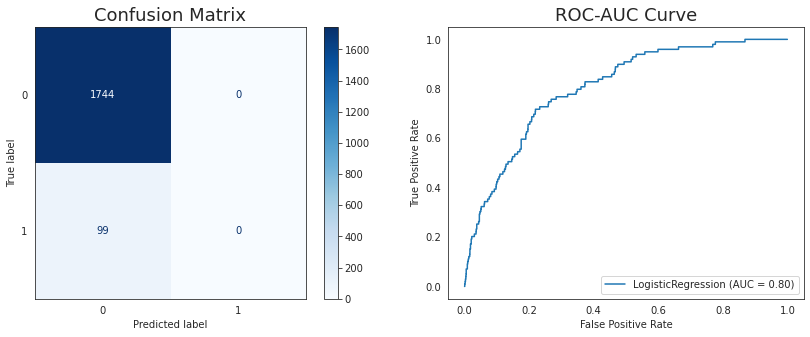

In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_sc, y_train)
print(f'The train score is {lr.score(X_train_sc, y_train)}')
print(f'The test score is {lr.score(X_test_sc, y_test)}')
pred = lr.predict(X_test_sc)
print(f'The roc_auc score is {roc_auc_score(y_test, pred)}')
print(f'The specificity/precision score is {precision_score(y_test, pred)}')
print(f'The sensitivity/recall score is {recall_score(y_test, pred)}')
print(f'The f1 score is {f1_score(y_test, pred)}')

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

########## Ploting the Confusion Matrix and ROC-AUC Curve ##########
sns.set_style("white")
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax = ax.ravel()
ax[0].set_title('Confusion Matrix',fontsize=18)
plot_confusion_matrix(lr, X_test_sc, y_test, cmap='Blues', values_format='d',ax=ax[0]);

ax[1].set_title('ROC-AUC Curve',fontsize=18)
plot_roc_curve(lr, X_test_sc, y_test,ax=ax[1]);

#### Model Benchmark (Logistic Regression w SMOTE)
---

Classification using class-imbalanced dataset is biased in favor of the majority class. For this project, we have over 7000 WNV-absent observations, but only close to 400 WNV-present ones.  The presence of imbalanced classes has negative impact on the model fitting process, and usually create classifiers that have poor predictive accuracy for the minority class and that tend to classify most new samples into the majority class. As such, we can rely on Synthetic Minority Oversampling TEchnique (SMOTE) as a means to oversample the the positive class (WNV-present) that we are attempting to predict for.

In [ ]:
#SMOTE as sample is imbalanced
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_sample(X_train_sc, y_train)

The train score is 0.7361828265442724
The test score is 0.6934346174715138
The roc_auc score is 0.7284484755815032
The specificity/precision score is 0.12297734627831715
The sensitivity/recall score is 0.7676767676767676
The f1 score is 0.21199442119944212
True Negatives: 1202
False Positives: 542
False Negatives: 23
True Positives: 76


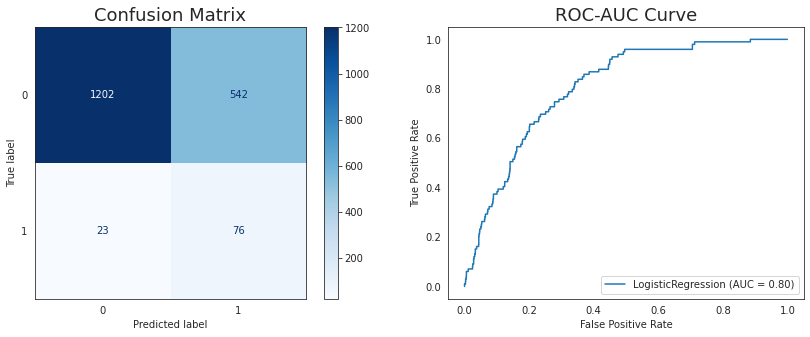

In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_smote, y_train_smote)
print(f'The train score is {lr.score(X_train_smote, y_train_smote)}')
print(f'The test score is {lr.score(X_test_sc, y_test)}')
pred = lr.predict(X_test_sc)
print(f'The roc_auc score is {roc_auc_score(y_test, pred)}')
print(f'The specificity/precision score is {precision_score(y_test, pred)}')
print(f'The sensitivity/recall score is {recall_score(y_test, pred)}')
print(f'The f1 score is {f1_score(y_test, pred)}')

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

########## Ploting the Confusion Matrix and ROC-AUC Curve ##########
sns.set_style("white")
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax = ax.ravel()
ax[0].set_title('Confusion Matrix',fontsize=18)
plot_confusion_matrix(lr, X_test_sc, y_test, cmap='Blues', values_format='d',ax=ax[0]);

ax[1].set_title('ROC-AUC Curve',fontsize=18)
plot_roc_curve(lr, X_test_sc, y_test,ax=ax[1]);

{'model': 'Logistic Regression',
 'params': 'Default',
 'train': 0.7419200611971696,
 'test': 0.6918068366793272,
 'roc': 0.7323521916411825,
 'specificity': 0.12359550561797752,
 'sensitivity': 0.7777777777777778,
 'f_score': 0.21329639889196675}

### METRICS ###
True Negatives: 1198
False Positives: 546
False Negatives: 22
True Positives: 77


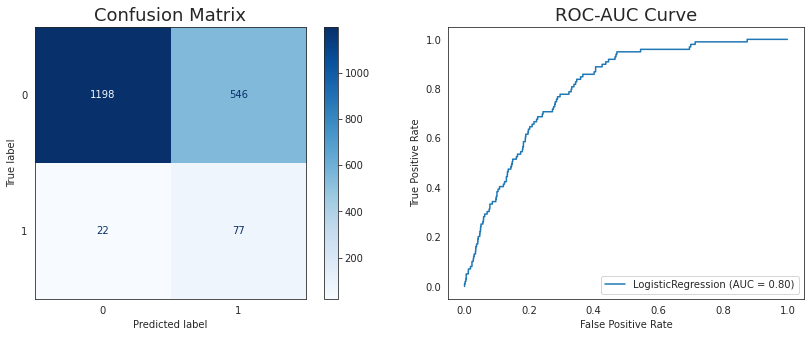

In [ ]:
#trained_lr = run_model('Logistic Regression', models['lr'], lr_params={}, False, True)
trained_lr = run_model('Logistic Regression', models['lr'], {}, False,True)

## Model Tuning
---

### Input hyperparameters for Models

In [ ]:
# Logistic Regression Model Tuning Hyperparameters
lr_params = {
    'max_iter': [1000],
    
    # Trying different types of regularization
    'solver': ['lbfgs', 'liblinear'],
    'penalty':['l2','l1'],
    
     # Trying different alphas of: 10, 1, 0.1 (C = 1/alpha)
    'C':[0.1, 1, 10],
    #'l1_ratio': [0.1, 0.5, 1.0]
}

In [ ]:
# KNN Model Tuning Hyperparameters
knn_params = {
    'n_neighbors': range(1, 51, 10),
    'p': [1, 2],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [ ]:
# Decision Tree Model Tuning Hyperparameters
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# Source: https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

dt_params = {
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [20, 40, 50],
    'min_samples_leaf': [5, 10, 20, 30], 
    'ccp_alpha': [0, 0.1, 1, 10]
}

In [ ]:
# Bagging Tree Model Tuning Hyperparameters
bag_params = {
    'n_estimators': [20, 30],
    'max_features': [20, 30],
    'n_jobs': [-1]
}

In [ ]:
# Gradient Boosting Model Tuning Hyperparameters
# Source: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

gb_params = {
    'learning_rate': [0.1, 0.5, 0.9],
    'n_estimators': [50, 60, 70],
    'max_depth': [None, 3, 4, 5, 7],
    'max_features': [10, 30, 50],
    'min_samples_split': [20, 40, 50],
    'min_samples_leaf': [5, 10, 20, 30]
}

In [ ]:
# Extra Tree Model Tuning Hyperparameters
# source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

et_params = {
    'n_estimators': [20, 30], 
    'max_depth': [None, 3, 4, 5],
    'max_features': [20, 30],
    'min_samples_split': [20, 40, 50],
    'min_samples_leaf': [5, 10, 20, 30],
    'n_jobs': [-1]
}

In [ ]:
# Random Forest Model Tuning Hyperparameters
# source: https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/
# source: https://builtin.com/data-science/random-forest-algorithm

rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 3, 4, 5],
    'max_features': [10, 30, 50],
    'min_samples_split': [1000, 1500, 2000],
    'min_samples_leaf':[30,50,60],
    'n_jobs': [-1]
}

In [ ]:
# ada Boost Model Tuning Hyperparameters
# source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

ada_params = {
    'n_estimators': [40, 50, 60, 100],
    'learning_rate': [0.1, 0.9, 1]
}

In [ ]:
# SVC Model Tuning Hyperparameters
# source: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html'

svc_params = {
    'C':[0.1, 1, 10],
    'gamma':[0.01, 0.1, 0.3], 
    'kernel':['linear','rbf']
}

In [ ]:
# XG Boost Model Tuning Hyperparameters
# Source: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

xgb_params = {
    'learning_rate': [0.1, 0.9, 1.0],
    'n_estimators' : [100, 300, 500],
    'max_depth' :  [3, 5, 7]
}

### Running model with hyperparameters and GridSearch Enabled
---

In [ ]:
ss, X_train_sc, X_test_sc, y_train, y_test = process(X, y)

#### Logistic Regression (SMOTE and GridSearch enabled)
---

Logistic regression is a statistical method for predicting binary classes. The outcome or target variable is dichotomous in nature. Dichotomous means there are only two possible classes. It computes the probability of an event occurrence. In this instance, we're using it to detect the presence of the WNV. 

It is a special case of linear regression where the target variable is categorical in nature. It uses a log of odds as the dependent variable. Logistic Regression predicts the probability of occurrence of a binary event utilizing a logit function.

The type of logistic regression that is created for this project is the **binary logistic regression** where the target variable has only 2 possible outcomes WNV present or no WNV present.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   39.7s finished


{'model': 'Logistic Regression',
 'params': {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'},
 'train': 0.7433543698603939,
 'test': 0.6999457406402605,
 'roc': 0.7223612269483829,
 'specificity': 0.12292358803986711,
 'sensitivity': 0.7474747474747475,
 'f_score': 0.21112696148359486}

### METRICS ###
True Negatives: 1216
False Positives: 528
False Negatives: 25
True Positives: 74


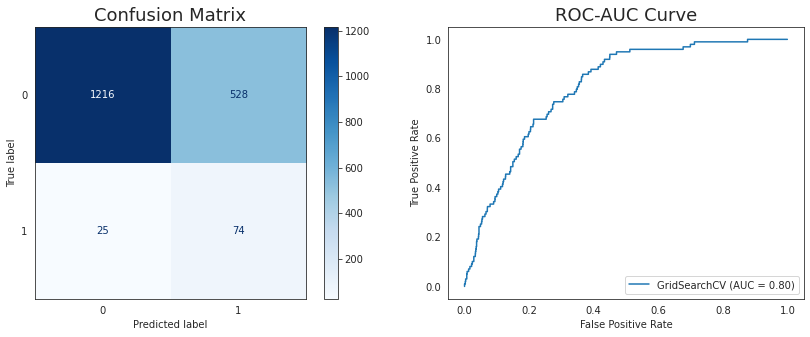

In [ ]:
trained_lr_sm = run_model('Logistic Regression', models['lr'], lr_params, True, True)

#### KNearestNeighbors (SMOTE and Gridsearch Enabled)
---

 The K Nearest Neighbors (KNN) model is commonly used for classification problems. It uses feature similarity to predict the class of new data points, in this case WNV present or not present, using 'K' nearest neighbors of each point. While KNN is one of the more simpler and intuitive models, it generally does not perform well on imbalanced data. As such, it is important to use techniques like SMOTE to ensure that results are not skewed towards the majority class.

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished


{'model': 'KNN',
 'params': {'metric': 'manhattan',
  'n_neighbors': 1,
  'p': 1,
  'weights': 'uniform'},
 'train': 0.9942627653471027,
 'test': 0.8784590341833967,
 'roc': 0.6023132703178574,
 'specificity': 0.15846994535519127,
 'sensitivity': 0.29292929292929293,
 'f_score': 0.20567375886524822}

### METRICS ###
True Negatives: 1590
False Positives: 154
False Negatives: 70
True Positives: 29


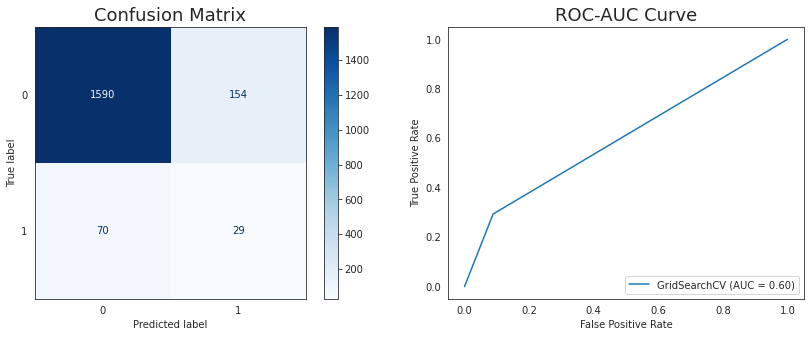

In [ ]:
trained_knn_sm = run_model('KNN', models['knn'], knn_params, True, True)

#### Decision Tree Classifer (SMOTE and Gridsearch Enabled)
---

Decision Tree (DT) is known for its robustness to noise, tolerance against missing information, handling of irrelevant, redundant predictive attribute values, low computational cost, interpretability, fast run time and robust predictors.

The Nodes with the DT are split based on impurity. Impurity is a measure of the homogeneity of the labels on a node. There are many ways to implement the impurity measure, two of which scikit-learn has implemented is the Information gain and **Gini Impurity** or Gini Index.
In a decision tree each internal node represents a 'test' on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). A node that has no children is a leaf.

Information gain uses the entropy measure as the impurity measure and splits a node such that it gives the most amount of information gain. Whereas Gini Impurity measures the divergences between the probability distributions of the target attribute’s values and splits a node such that it gives the least amount of impurity.


$$
\begin{eqnarray*}
\text{Gini impurity} &=& 1 - \sum_{i=1}^{classes} P(\text{class i})^2 \\
\text{Gini impurity (2 classes)} &=& 1 - P(\text{class 1})^2 - P(\text{class 2})^2 \\
text{Gini impurity (3 classes)} &=& 1 - P(\text{class 1})^2 - P(\text{class 2})^2 - P(\text{class 3})^2 \\
\end{eqnarray*}
$$


Limtation of DT: <br>

1. Decision trees can very easily overfit due to variance

2. Decision trees are locally optimal.

3. Decision trees don't work well with unbalanced data.

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   42.2s finished


{'model': 'DT',
 'params': {'ccp_alpha': 0,
  'max_depth': None,
  'min_samples_leaf': 5,
  'min_samples_split': 20},
 'train': 0.9381334863262574,
 'test': 0.8817145957677699,
 'roc': 0.5992696460012974,
 'specificity': 0.16,
 'sensitivity': 0.2828282828282828,
 'f_score': 0.20437956204379565}

### METRICS ###
True Negatives: 1597
False Positives: 147
False Negatives: 71
True Positives: 28


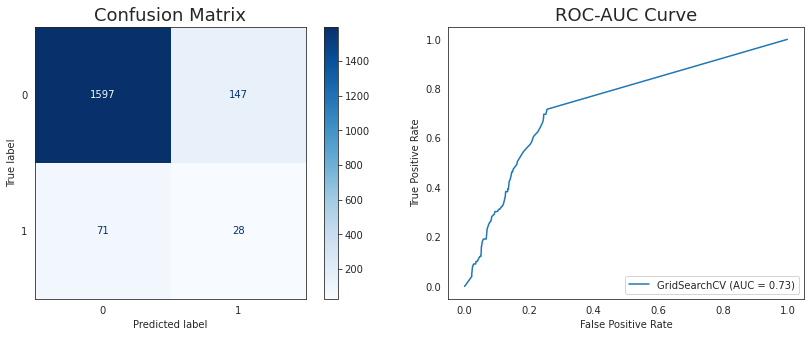

In [ ]:
trained_dt_sm = run_model('DT', models['dt'], dt_params, True, True)

#### Bagging Tree Classifer (SMOTE and Gridsearch Enabled)
---

Part of an Ensemble methods, Bagging Tree Classifier combines several decision trees to produce better predictive performance than utilizing a single decision tree. The main principle behind the ensemble model is that a group of weak learners come together to form a strong learner.

Bagging (Bootstrap Aggregation) is used to reduce the variance of a decision tree by creating several subsets of data from training sample chosen randomly with replacement. Now, each collection of subset data is used to train their decision trees. As a result, we end up with an ensemble of different models. Average of all the predictions from different trees are used which is more robust than a single decision tree.

With bagged decision trees, we generate many different trees on pretty similar data. These trees are strongly correlated with one another. Because these trees are correlated with one another, they will have high variance. Looking at the variance of the average of two random variables  𝑇1  and  𝑇2 :

𝑉𝑎𝑟((𝑇1+𝑇2)/2) = 1/4 * (𝑉𝑎𝑟(𝑇1) + 𝑉𝑎𝑟(𝑇2) + 2𝐶𝑜𝑣(𝑇1,𝑇2))
 
If  𝑇1  and  𝑇2  are highly correlated, then the variance will about as high as we'd see with individual decision trees. By "de-correlating" our trees from one another, we can drastically reduce the variance of our model.

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   24.4s finished


{'model': 'Bag',
 'params': {'max_features': 20, 'n_estimators': 30, 'n_jobs': -1},
 'train': 0.9935934213042646,
 'test': 0.9028757460661965,
 'roc': 0.5771041840422574,
 'specificity': 0.1721311475409836,
 'sensitivity': 0.21212121212121213,
 'f_score': 0.19004524886877827}

### METRICS ###
True Negatives: 1643
False Positives: 101
False Negatives: 78
True Positives: 21


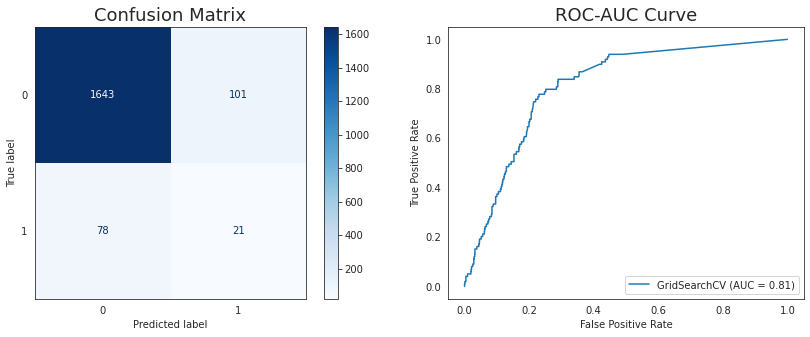

In [ ]:
trained_bag_sm = run_model('Bag', models['bag'], bag_params, True, True)

#### Random Forest Classifer (SMOTE and Gridsearch Enabled)
---

Random Forest is an extension over bagging. It takes one extra step where in addition to taking the random subset of data, it also takes the random selection of features rather than using all features to grow trees.This results in a wide diversity that generally results in a better model.



Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 37.8min finished


{'model': 'RF',
 'params': {'max_depth': None,
  'max_features': 30,
  'min_samples_leaf': 30,
  'min_samples_split': 1000,
  'n_estimators': 100,
  'n_jobs': -1},
 'train': 0.802065404475043,
 'test': 0.7590884427563754,
 'roc': 0.7631388425539802,
 'specificity': 0.1529175050301811,
 'sensitivity': 0.7676767676767676,
 'f_score': 0.2550335570469799}

### METRICS ###
True Negatives: 1323
False Positives: 421
False Negatives: 23
True Positives: 76


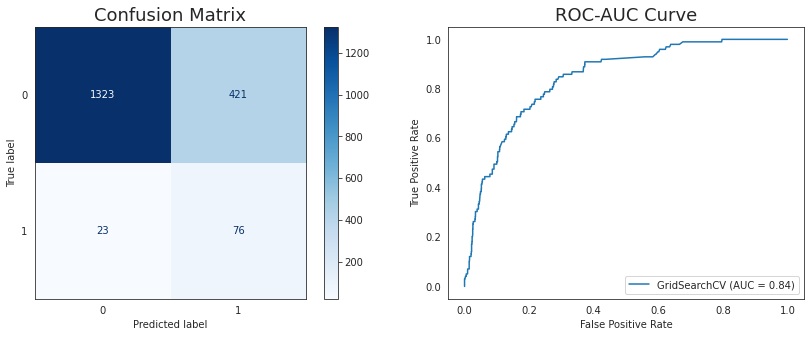

In [ ]:
trained_rf_sm = run_model('RF', models['rf'], rf_params, True, True)

#### Gradient Boosting Classifer (SMOTE and Gridsearch Enabled)
---

Gradient Boosting Classifier typically uses decision trees as base learners, from which an ensemble of such learners will form the final prediction model. 

However, unlike bagging where we build many independent models and combine them using a certain averaging technique, boosting involves building of predictors in a sequential manner where subsequent models learn from the misclassifications (a.k.a errors) of the previous models. Each learner contributes by minimizing the loss function of the whole model via gradient descent method.

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 1310 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 2248 tasks      | elapsed: 40.9min
[Parallel(n_jobs=-1)]: Done 2992 tasks      | elapsed: 72.4min
[Parallel(n_jobs=-1)]: Done 4156 tasks      | elapsed: 93.1min
[Parallel(n_jobs=-1)]: Done 5588 tasks      | elapsed: 122.3min
[Parallel(n_jobs=-1)]: Done 6830 tasks      | elapsed: 159.2min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed: 179.5min finished


{'model': 'GB',
 'params': {'learning_rate': 0.5,
  'max_depth': 7,
  'max_features': 30,
  'min_samples_leaf': 5,
  'min_samples_split': 50,
  'n_estimators': 70},
 'train': 0.9919678714859438,
 'test': 0.9175257731958762,
 'roc': 0.5514983551107404,
 'specificity': 0.1728395061728395,
 'sensitivity': 0.1414141414141414,
 'f_score': 0.15555555555555553}

### METRICS ###
True Negatives: 1677
False Positives: 67
False Negatives: 85
True Positives: 14


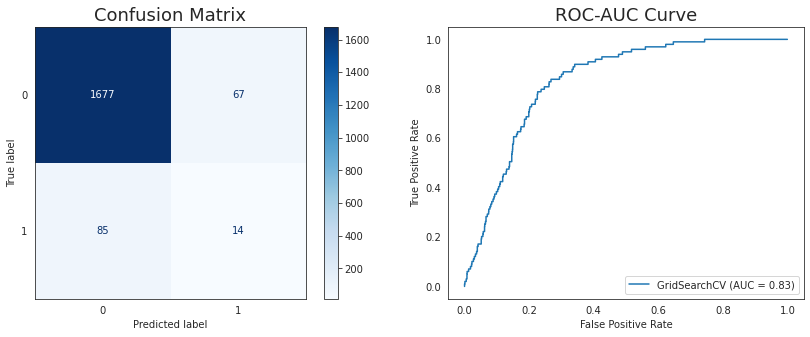

In [ ]:
trained_gb_sm = run_model('GB', models['gb'], gb_params, True, True)

#### Extra Trees Classifer (SMOTE and Gridsearch Enabled)
---

Extra Trees Classifier, similar to ordinary random forests in that they are an ensemble of individual trees, has two main differences: first, each tree is trained using the whole learning sample (rather than a bootstrap sample), and second, the top-down splitting in the tree learner is randomized. 

Instead of computing the locally optimal cut-point for each feature under consideration (based on, e.g., information gain or the Gini impurity), a random cut-point is selected. This value is selected from a uniform distribution within the feature's empirical range (in the tree's training set). Then, of all the randomly generated splits, the split that yields the highest score is chosen to split the node. 

Similar to ordinary random forests, the number of randomly selected features to be considered at each node can be specified. Default values for this parameter are sqrt(p) for classification and p for regression, where p is the number of features in the model.

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  3.6min finished


{'model': 'ET',
 'params': {'max_depth': None,
  'max_features': 30,
  'min_samples_leaf': 5,
  'min_samples_split': 20,
  'n_estimators': 30,
  'n_jobs': -1},
 'train': 0.9357429718875502,
 'test': 0.8686923494302767,
 'roc': 0.6781374525067185,
 'specificity': 0.19574468085106383,
 'sensitivity': 0.46464646464646464,
 'f_score': 0.2754491017964072}

### METRICS ###
True Negatives: 1555
False Positives: 189
False Negatives: 53
True Positives: 46


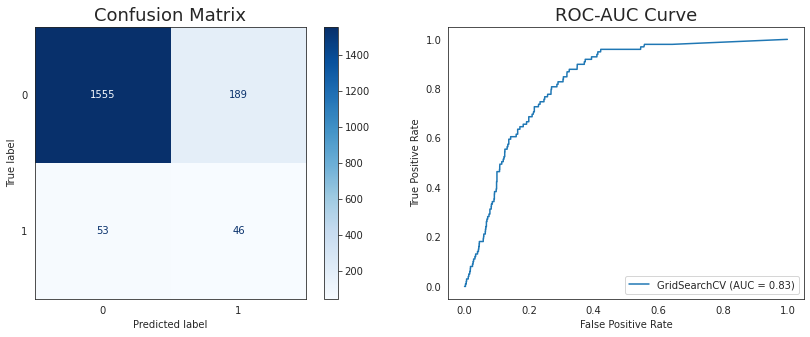

In [ ]:
trained_et_sm = run_model('ET', models['et'], et_params, True, True)

#### AdaBoost Classifer (SMOTE and Gridsearch Enabled)
---

Adaboost also builds an ensemble of weak learners in a sequential manner. At every iteration, it adjusts the weights attached to each instance in the sample distribution by increasing the weights of the misclassified instances and decreasing for correctly predicted ones. After training, the weak learner is added to the ensemble with an associated weight that is contingent on its performance, i.e the better it performs, the more it contributes to the overall prediction outcome.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   47.2s finished


{'model': 'AdaBoost',
 'params': {'learning_rate': 1, 'n_estimators': 100},
 'train': 0.8607764390896921,
 'test': 0.8133478024959305,
 'roc': 0.7727533361134279,
 'specificity': 0.18508997429305912,
 'sensitivity': 0.7272727272727273,
 'f_score': 0.2950819672131147}

### METRICS ###
True Negatives: 1427
False Positives: 317
False Negatives: 27
True Positives: 72


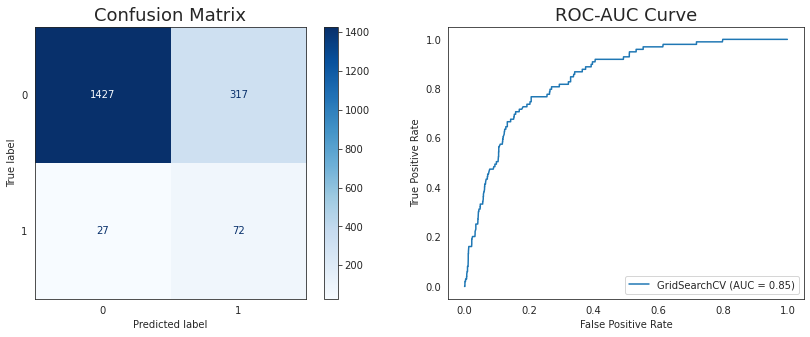

In [ ]:
trained_ada_sm = run_model('AdaBoost', models['ada'], ada_params, True, True)

#### SVC (SMOTE and Gridsearch Enabled)
---

Support Vector Machine (SVM) attempts to find a hyperplane that divides a given dataset into its respective underlying classes. This is done with the use of support vectors (data-points derived from the words), from which the SVM algorithm would establish a hyperplane that generates the greatest margin between it and the support vectors.

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  8.9min finished


{'model': 'SVC',
 'params': {'C': 10, 'gamma': 0.3, 'kernel': 'rbf'},
 'train': 0.9408108624976095,
 'test': 0.850244167118828,
 'roc': 0.6255154758595126,
 'specificity': 0.14741035856573706,
 'sensitivity': 0.37373737373737376,
 'f_score': 0.21142857142857144}

### METRICS ###
True Negatives: 1530
False Positives: 214
False Negatives: 62
True Positives: 37


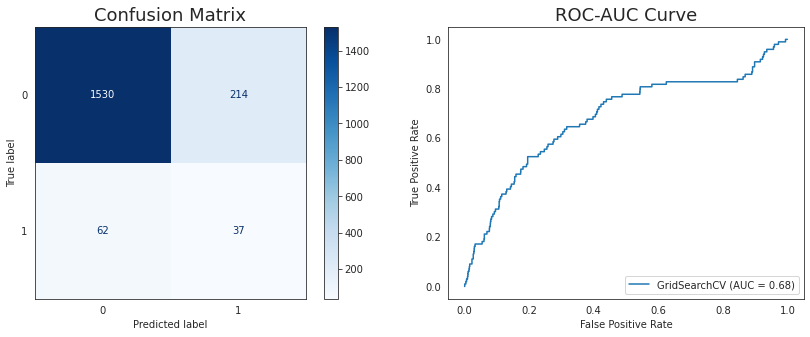

In [ ]:
trained_svc_sm = run_model('SVC', models['svc'], svc_params, True,True)

#### XG Boost Classifer (SMOTE and Gridsearch Enabled)
---

XGBoost stands for Extreme Gradient Boosting, and is a specific implementation of Gradient Boosting with several other features, such as regularization to counteract the inclination to overfit in Gradient Boosting, and built-in capability to handle missing values. 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 133.0min


[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 350.3min finished
[12:28:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'model': 'XGB',
 'params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500},
 'train': 0.9832663989290495,
 'test': 0.9213239283776451,
 'roc': 0.5725604670558799,
 'specificity': 0.21951219512195122,
 'sensitivity': 0.18181818181818182,
 'f_score': 0.19889502762430936}

### METRICS ###
True Negatives: 1680
False Positives: 64
False Negatives: 81
True Positives: 18


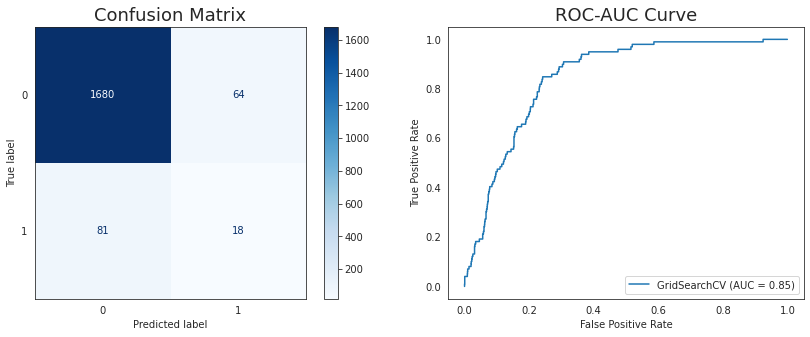

In [ ]:
trained_xgb_sm = run_model('XGB', models['xgb'], xgb_params, True, True)

## Model Evaluation
---

In [ ]:
# Turning Evaluated List into a DataFrame
eval_df_exp5 = pd.DataFrame(eval_list)
eval_df_exp5.to_csv('../assets/eval_df_exp5.csv', index=False)

In [ ]:
model_result_exp5 = pd.read_csv('../assets/eval_df_exp5.csv')
model_result_exp5

,model,params,train,test,roc,specificity,sensitivity,f_score
0,Logistic Regression,Default,0.741920,0.691807,0.732352,0.123596,0.777778,0.213296
1,Logistic Regression,"{'C': 10, 'max_iter': 1000, 'penalty': 'l2', '...",0.743354,0.699946,0.722361,0.122924,0.747475,0.211127
2,KNN,"{'metric': 'manhattan', 'n_neighbors': 1, 'p':...",0.994263,0.878459,0.602313,0.158470,0.292929,0.205674
3,DT,"{'ccp_alpha': 0, 'max_depth': None, 'min_sampl...",0.938133,0.881715,0.599270,0.160000,0.282828,0.204380
4,Bag,"{'max_features': 20, 'n_estimators': 30, 'n_jo...",0.993593,0.902876,0.577104,0.172131,0.212121,0.190045
5,RF,"{'max_depth': None, 'max_features': 30, 'min_s...",0.802065,0.759088,0.763139,0.152918,0.767677,0.255034
6,GB,"{'learning_rate': 0.5, 'max_depth': 7, 'max_fe...",0.991968,0.917526,0.551498,0.172840,0.141414,0.155556
7,ET,"{'max_depth': None, 'max_features': 30, 'min_s...",0.935743,0.868692,0.678137,0.195745,0.464646,0.275449
8,AdaBoost,"{'learning_rate': 1, 'n_estimators': 100}",0.860776,0.813348,0.772753,0.185090,0.727273,0.295082
9,SVC,"{'C': 10, 'gamma': 0.3, 'kernel': 'rbf'}",0.940811,0.850244,0.625515,0.147410,0.373737,0.211429


## Model Insights
---

#### Extraction of coefficients from Logistic Regression 

In [ ]:
coef_list = trained_lr_sm.best_estimator_.coef_[0]
features = [col for col in X.columns]
coefficient_df = pd.DataFrame({'Feature': features, 'Coefficient_Value': coef_list})
coefficient_df.sort_values('Coefficient_Value', ascending=False, inplace=True)
coefficient_df = coefficient_df.reindex(coefficient_df.loc[:,'Coefficient_Value'].abs().sort_values(ascending=False).index)
coefficient_df.reset_index(drop=True, inplace=True)
coefficient_df.head(15)

,Feature,Coefficient_Value
0,WetBulb,4.522253
1,Tavg_mean_past14day,-4.177736
2,daylight_duration_in_minutes,-3.189733
3,Depart,-3.140529
4,Cool_mean_past14day,3.134303
5,DewPoint,-2.623429
6,WetBulb_mean_past7day,2.504400
7,week_of_year,-1.868599
8,Cool_mean_past7day,-1.637482
9,species_culex_territans,-1.217845


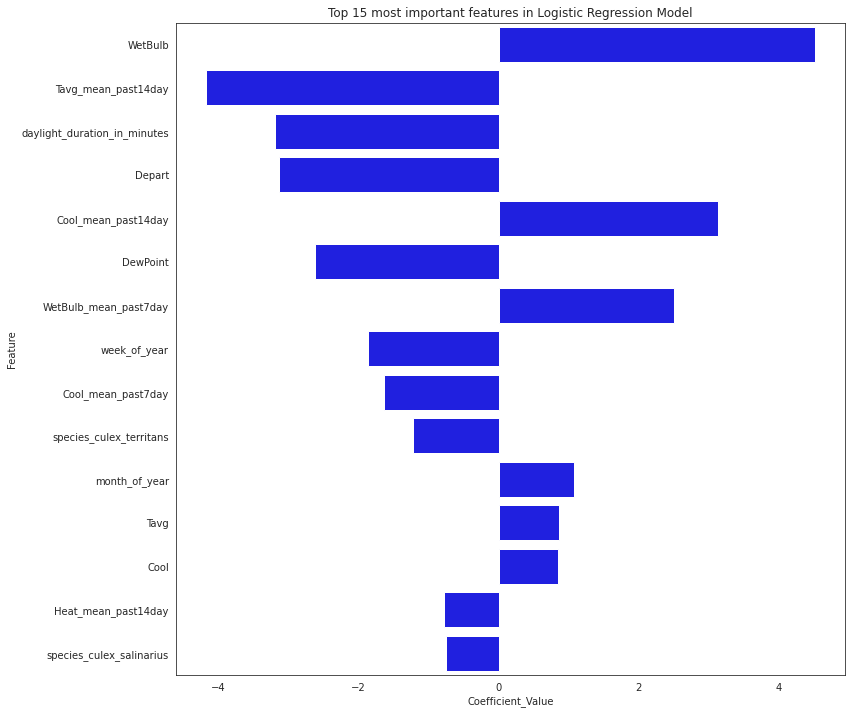

In [ ]:
#coefficient_df.plot(color='Blue', kind='barh', figsize=(12, 12))
plt.figure(figsize=(12, 12))
plt.title('Top 15 most important features in Logistic Regression Model')
sns.barplot(data=coefficient_df.head(15), x='Coefficient_Value', y='Feature', color='Blue')
plt.show();

## Submission to Kaggle
---

### Read in Kaggle data

In [ ]:
test_kaggle_exp5 = pd.read_csv('../assets/test_final_v2_daylight_exp5.csv')

### Drop Id column and assign to new dataframe

In [ ]:
test_kaggle = test_kaggle_exp5.drop(columns='Id')

### Inspect Kaggle data

In [ ]:
X_train_sc.shape

(5527, 37)

In [ ]:
test_kaggle.shape

(116293, 37)

In [ ]:
test_kaggle.head()

,Latitude,Longitude,species_culex_erraticus,species_culex_pipiens,species_culex_pipiens_restuans,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,species_unspecified_culex,month_of_year,week_of_year,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Tavg_mean_past7day,WetBulb_mean_past7day,Heat_mean_past7day,Cool_mean_past7day,AvgSpeed_mean_past7day,PrecipTotal_mean_past7day,Tavg_mean_past14day,WetBulb_mean_past14day,Heat_mean_past14day,Cool_mean_past14day,AvgSpeed_mean_past14day,PrecipTotal_mean_past14day,daylight_duration_in_minutes
0,41.95469,-87.800991,0,0,1,0,0,0,0,0,6,24,74,7,56,64,0,9,0.0,29.28,29.99,8.9,18,10.0,74.142857,68.142857,0.0,9.142857,12.6,0.304571,69.428571,62.928571,1.0,5.428571,9.95,0.218857,910.0
1,41.95469,-87.800991,0,0,0,1,0,0,0,0,6,24,74,7,56,64,0,9,0.0,29.28,29.99,8.9,18,10.0,74.142857,68.142857,0.0,9.142857,12.6,0.304571,69.428571,62.928571,1.0,5.428571,9.95,0.218857,910.0
2,41.95469,-87.800991,0,1,0,0,0,0,0,0,6,24,74,7,56,64,0,9,0.0,29.28,29.99,8.9,18,10.0,74.142857,68.142857,0.0,9.142857,12.6,0.304571,69.428571,62.928571,1.0,5.428571,9.95,0.218857,910.0
3,41.95469,-87.800991,0,0,0,0,1,0,0,0,6,24,74,7,56,64,0,9,0.0,29.28,29.99,8.9,18,10.0,74.142857,68.142857,0.0,9.142857,12.6,0.304571,69.428571,62.928571,1.0,5.428571,9.95,0.218857,910.0
4,41.95469,-87.800991,0,0,0,0,0,0,1,0,6,24,74,7,56,64,0,9,0.0,29.28,29.99,8.9,18,10.0,74.142857,68.142857,0.0,9.142857,12.6,0.304571,69.428571,62.928571,1.0,5.428571,9.95,0.218857,910.0


### Adhoc load model for Kaggle scoring

In [ ]:
selected_model = trained_lr_sm

### Transform Kaggle data

In [ ]:
test_kaggle_sc = ss.transform(test_kaggle)

In [ ]:
test_kaggle_sc = pd.DataFrame(test_kaggle_sc, columns=test_kaggle.columns.tolist())
test_kaggle_sc.head()

,Latitude,Longitude,species_culex_erraticus,species_culex_pipiens,species_culex_pipiens_restuans,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,species_unspecified_culex,month_of_year,week_of_year,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Tavg_mean_past7day,WetBulb_mean_past7day,Heat_mean_past7day,Cool_mean_past7day,AvgSpeed_mean_past7day,PrecipTotal_mean_past7day,Tavg_mean_past14day,WetBulb_mean_past14day,Heat_mean_past14day,Cool_mean_past14day,AvgSpeed_mean_past14day,PrecipTotal_mean_past14day,daylight_duration_in_minutes
0,0.92815,-1.227595,-0.013452,-0.538096,1.094356,-0.633817,-0.093599,-0.023304,-0.158231,0.0,-1.517439,-1.494776,0.172239,0.705453,-0.403779,-0.064436,-0.35032,0.058996,-0.413813,-0.149402,0.274966,1.034023,0.01239,1.009752,0.329519,0.814444,-0.476902,0.254595,4.141989,0.991738,-0.593643,-0.233297,0.230842,-0.661917,2.180462,0.837803,1.094683
1,0.92815,-1.227595,-0.013452,-0.538096,-0.913780,1.577741,-0.093599,-0.023304,-0.158231,0.0,-1.517439,-1.494776,0.172239,0.705453,-0.403779,-0.064436,-0.35032,0.058996,-0.413813,-0.149402,0.274966,1.034023,0.01239,1.009752,0.329519,0.814444,-0.476902,0.254595,4.141989,0.991738,-0.593643,-0.233297,0.230842,-0.661917,2.180462,0.837803,1.094683
2,0.92815,-1.227595,-0.013452,1.858404,-0.913780,-0.633817,-0.093599,-0.023304,-0.158231,0.0,-1.517439,-1.494776,0.172239,0.705453,-0.403779,-0.064436,-0.35032,0.058996,-0.413813,-0.149402,0.274966,1.034023,0.01239,1.009752,0.329519,0.814444,-0.476902,0.254595,4.141989,0.991738,-0.593643,-0.233297,0.230842,-0.661917,2.180462,0.837803,1.094683
3,0.92815,-1.227595,-0.013452,-0.538096,-0.913780,-0.633817,10.683905,-0.023304,-0.158231,0.0,-1.517439,-1.494776,0.172239,0.705453,-0.403779,-0.064436,-0.35032,0.058996,-0.413813,-0.149402,0.274966,1.034023,0.01239,1.009752,0.329519,0.814444,-0.476902,0.254595,4.141989,0.991738,-0.593643,-0.233297,0.230842,-0.661917,2.180462,0.837803,1.094683
4,0.92815,-1.227595,-0.013452,-0.538096,-0.913780,-0.633817,-0.093599,-0.023304,6.319869,0.0,-1.517439,-1.494776,0.172239,0.705453,-0.403779,-0.064436,-0.35032,0.058996,-0.413813,-0.149402,0.274966,1.034023,0.01239,1.009752,0.329519,0.814444,-0.476902,0.254595,4.141989,0.991738,-0.593643,-0.233297,0.230842,-0.661917,2.180462,0.837803,1.094683


### Perform prediction on Kaggle data

In [ ]:
kaggle = pd.DataFrame()
pred = selected_model.predict(test_kaggle_sc)
kaggle['Id'] = test_kaggle_exp5['Id']
kaggle['WnvPresent'] = pred

### Inspect predictions

In [ ]:
kaggle.head()

,Id,WnvPresent
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
kaggle.WnvPresent.value_counts()

0    105151
1     11142
Name: WnvPresent, dtype: int64

In [ ]:
kaggle.WnvPresent.value_counts(normalize=True)

0    0.90419
1    0.09581
Name: WnvPresent, dtype: float64

### Save predictions for submission to Kaggle for scoring

In [ ]:
kaggle.to_csv('../assets/kaggle_lr_exp5.csv', index=False)

### Final Kaggle Score

Kaggle submission of predictions made by the selected Logistic Regression model yielded the following scores:

<img src='../images/KaggleScore_NoCodeSum.png'>

## Conclusion
---

We did not proceed to drop CodeSum as the Sensitivity and ROC-AUC scores for the model without CodeSum were lower compared to the original modeling run and the new model did not yield significantly better results on Kaggle.